# Optimizing variables over transition rate


In this notebook we are going to implement the method presented in Mouaffac etal. (J. Chem. Theory Comput. 2023, 19, 17, 5701–5711) on a simple 2D example.

In [1]:
import numpy as np
import folie as fl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.optimize

In [2]:
# Define model to simulate and type of simulator to use
dt = 1e-3

potential=fl.functions.MullerBrown()
diff_function = fl.functions.Polynomial(deg=0, coefficients=np.asarray([0.5]) * np.eye(2, 2))
model_simu = fl.models.overdamped.Overdamped(force=potential, diffusion=diff_function)


(36, 36) (36, 36)


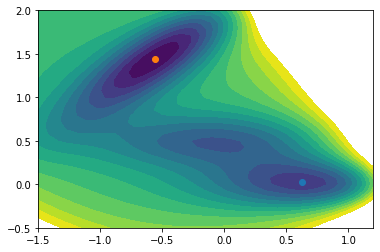

In [3]:
x = np.linspace(-1.5, 1.2, 36)
y = np.linspace(-0.5, 2.0, 36)

X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)

# Plot potential surface
pot = potential.potential_plot(X, Y)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))

# Also find the two minima of the potential

product = scipy.optimize.minimize(lambda x:potential.potential(x.reshape(1,-1)), x0=[0.5, 0]).x.reshape(1,-1)  # minima one
reactant = scipy.optimize.minimize(lambda x:potential.potential(x.reshape(1,-1)), x0=[-0.5, 1.5]).x.reshape(1,-1)  # minima two
ax.scatter(*product[0])
ax.scatter(*reactant[0])

Lets run some simulations of the model. We launch simulations from the transition state to obtain a full sampling of the transition.

In [4]:
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)

# initialize positions
ntraj = 30
q0 = np.empty(shape=[ntraj, 2])
for i in range(ntraj):
    q0[i,:] = [-0.90,0.500]

# Calculate Trajectory
time_steps = 20000
data = simulator.run(time_steps, q0, save_every=1)


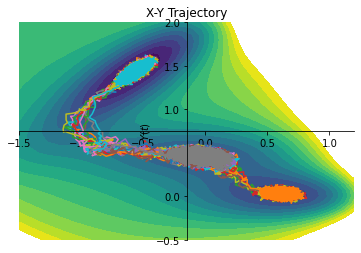

In [5]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
axs.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
for n, trj in enumerate(data):
    axs.plot(trj["x"][:, 0], trj["x"][:, 1])
    axs.spines["left"].set_position("center")
    axs.spines["right"].set_color("none")
    axs.spines["bottom"].set_position("center")
    axs.spines["top"].set_color("none")
    axs.xaxis.set_ticks_position("bottom")
    axs.yaxis.set_ticks_position("left")
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

Next step is to define a projection of the trajectories onto a 1d coordinate. We are using a simple neural network to define the projection.

In [6]:
# Transform data into torch tensor
est=fl.KramersMoyalEstimator(model_simu)
for trj in data:
    est.preprocess_traj(trj)
xt_torch=torch.Tensor(np.concatenate([(trj["xt"]) for trj in data], axis=0))
x_torch=torch.Tensor(np.concatenate([(trj["x"]) for trj in data], axis=0))

In [7]:
print(xt_torch)
print(x_torch)

tensor([[-0.8976,  0.5424],
        [-0.8997,  0.5118],
        [-0.9206,  0.5142],
        ...,
        [-0.5771,  1.4251],
        [-0.5758,  1.4236],
        [-0.5777,  1.4391]])
tensor([[-0.8914,  0.5205],
        [-0.8976,  0.5424],
        [-0.8997,  0.5118],
        ...,
        [-0.5487,  1.4204],
        [-0.5771,  1.4251],
        [-0.5758,  1.4236]])


tensor([[0.4953],
        [0.4984],
        [0.5092],
        ...,
        [0.5854],
        [0.5871],
        [0.5873]], grad_fn=<SigmoidBackward0>)
[[0.3758769  0.38145566 0.38708204 ... 0.5783235  0.5844874  0.5905404 ]
 [0.37975845 0.38539338 0.39107588 ... 0.583707   0.5898512  0.59585893]
 [0.3837274  0.38941947 0.39515907 ... 0.58910847 0.59519506 0.6011453 ]
 ...
 [0.545714   0.55231535 0.5588983  ... 0.7371881  0.7413204  0.745344  ]
 [0.55131656 0.5579024  0.56446797 ... 0.7412516  0.74532187 0.7492847 ]
 [0.55690604 0.56347483 0.57002145 ... 0.7452678  0.74927634 0.75317895]]


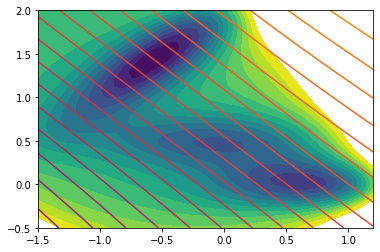

In [40]:
#initialization of the neural network
input_size = 2
output_size = 1
projection = nn.Sequential(
    nn.Linear(input_size, 2), nn.ELU(),
#     nn.Linear(8, 8), nn.ELU(),
    nn.Linear(2, 1), nn.Sigmoid()
)

print(projection(x_torch))

# Show the initial cv
new_cv = projection(torch.Tensor(np.column_stack([X.ravel(),Y.ravel()]))).detach().numpy().reshape(X.shape)
print(new_cv)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))

Let's now create the model

In [9]:
domain = fl.MeshedDomain.create_from_range(np.linspace(0,1, 10).ravel())
model_fit = fl.models.OverdampedSplines1D(domain=domain)

(599970, 1)


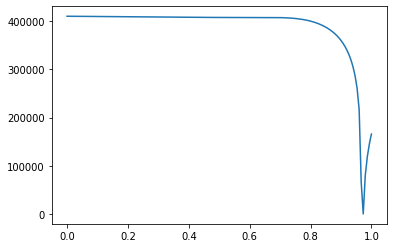

In [41]:

est=fl.KramersMoyalEstimator(model_fit)
data_proj = fl.Trajectories()
data_proj.append({"x": projection(x_torch).detach().numpy(), "xt": projection(xt_torch).detach().numpy(), "dt":dt})
print(data_proj[0]["x"].shape)
est.fit(data_proj)
pmf=fl.analysis.free_energy_profile_1d(model_fit, np.linspace(0.01,0.99,150))
plt.plot(np.linspace(0,1,150), pmf)

In [42]:
proj_product=projection(torch.Tensor(product)).detach().numpy()[0,0]
proj_reactant=projection(torch.Tensor(reactant)).detach().numpy()[0,0]
print(proj_reactant,proj_product)
mfpt = fl.analysis.mfpt_1d(model_fit,x_end=proj_product, x_range=[0.01,0.99], x_start=proj_reactant)
print(mfpt)

0.5932195 0.58369637
0.0012066619370260908


In [43]:
def optimize_rate(params, params_shape):
    # Restore params shapes
    arrs=np.split(init_params, np.cumsum([np.prod(s) for s in params_shape]))
    reshaped_params= [a.reshape(s) for a,s in zip(arrs,params_shape)]
    for p,new_p in zip(projection.parameters(),reshaped_params):
        p.data = torch.Tensor(new_p)
    data_proj = fl.Trajectories()
    data_proj.append({"x": projection(x_torch).detach().numpy(), "xt": projection(xt_torch).detach().numpy(), "dt":dt})
    est.fit(data_proj)
    proj_product=projection(torch.Tensor(product)).detach().numpy()[0,0]
    proj_reactant=projection(torch.Tensor(reactant)).detach().numpy()[0,0]
    mfpt = fl.analysis.mfpt_1d(model_fit,x_end=proj_product, x_range=[0.01,0.99], x_start=proj_reactant)
    return -np.log(mfpt)

We can now run the optimisation

In [44]:
from scipy.optimize import minimize

# Get initial parameters
params_shape = [p.detach().numpy().shape for p in projection.parameters()]
init_params=np.concatenate([p.detach().numpy().ravel() for p in projection.parameters()])
print(init_params, params_shape)
print([p.detach().numpy().ravel() for p in projection.parameters()])
    
res=minimize(optimize_rate, init_params, args=(params_shape,), method='Nelder-Mead', tol=1e-7)
print(res)

[ 0.17029493  0.3858365  -0.3436262  -0.11233239 -0.01068187  0.25053445
  0.6170864  -0.6999819   0.29555383] [(2, 2), (2,), (1, 2), (1,)]
[array([ 0.17029493,  0.3858365 , -0.3436262 , -0.11233239], dtype=float32), array([-0.01068187,  0.25053445], dtype=float32), array([ 0.6170864, -0.6999819], dtype=float32), array([0.29555383], dtype=float32)]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.719897461411886
             x: [ 1.703e-01  3.858e-01 -3.436e-01 -1.123e-01 -1.068e-02
                  2.505e-01  6.171e-01 -7.000e-01  2.956e-01]
           nit: 20
          nfev: 219
 final_simplex: (array([[ 1.703e-01,  3.858e-01, ..., -7.000e-01,
                         2.956e-01],
                       [ 1.703e-01,  3.858e-01, ..., -7.000e-01,
                         2.956e-01],
                       ...,
                       [ 1.703e-01,  3.858e-01, ..., -7.000e-01,
                         2.956e-01],
              

In [45]:
print("Final MFPT",np.exp(-res.fun))

Final MFPT 0.001206661937026091


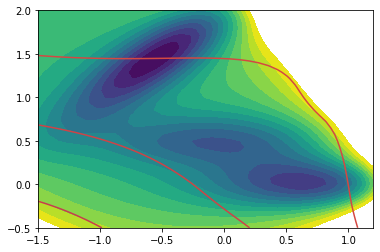

In [16]:
# Plot the new cv
new_cv = projection(torch.Tensor(np.column_stack([X.ravel(),Y.ravel()]))).detach().numpy().reshape(X.shape)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))

(599970, 1)


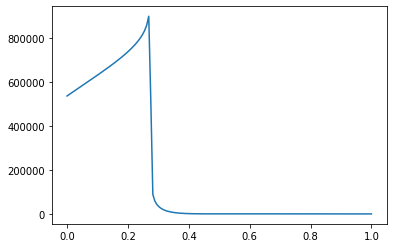

In [39]:
est=fl.KramersMoyalEstimator(model_fit)
data_proj = fl.Trajectories()
data_proj.append({"x": projection(x_torch).detach().numpy(), "xt": projection(xt_torch).detach().numpy(), "dt":dt})
print(data_proj[0]["x"].shape)
est.fit(data_proj)
pmf=fl.analysis.free_energy_profile_1d(model_fit, np.linspace(0.2,0.8,150))
plt.plot(np.linspace(0,1,150), pmf)

For comparison, a computation of the committor can be done. The committor is the optimal variable.

In [20]:
import skfem
state_radius = 0.05

def locate_R(x):
    return ((x - reactant.T) ** 2).sum(axis=0) < state_radius ** 2


def locate_P(x):
    return ((x - product.T) ** 2).sum(axis=0) < state_radius ** 2


# Build 2D mesh
N_points = 50
line_points_x = np.linspace(-1.5, 1.2, N_points)
line_points_y = np.linspace(-0.5, 2.0, N_points)
m = skfem.MeshTri().init_tensor(*(line_points_x, line_points_y))
m = m.with_subdomains({"reactant": locate_R, "product": locate_P})
# m = m.with_boundaries({"reactant": lambda x:((x -min_pot_R) ** 2).sum(axis=0) < state_radius ** 2, "product": lambda x:((x -min_pot_P) ** 2).sum(axis=0) < state_radius ** 2})
e = skfem.ElementTriP2()

u_sol, states_fem, basis = fl.analysis.solve_committor_fem(model_simu, m, e, bc="domains")

In [21]:
def apply_committor(X):
    return basis.probes(X.T) @ ((u_sol + 1) / 2)

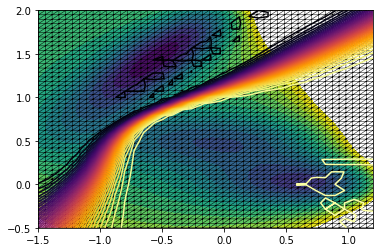

In [22]:
from skfem.visuals.matplotlib import plot, draw

fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
draw(m, ax=ax)
new_cv = apply_committor(np.column_stack([X.ravel(),Y.ravel()])).reshape(X.shape)


ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))


We can then explore the projected model on the optimal CV

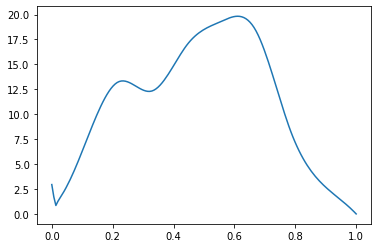

In [26]:
domain = fl.MeshedDomain.create_from_range(np.linspace(-1e-4,1+1e-4, 10).ravel())
model_committor = fl.models.OverdampedSplines1D(domain=domain)
projected_on_committor_data = fl.Trajectories(dt=dt)
for trj in data:
    projected_on_committor_data.append(apply_committor(trj["x"]).reshape(-1,1))

est=fl.KramersMoyalEstimator(model_committor)
est.fit(projected_on_committor_data)
pmf=fl.analysis.free_energy_profile_1d(model_committor, np.linspace(0.01,0.99,150))
plt.plot(np.linspace(0,1,150), pmf)

In [28]:
proj_product=apply_committor(product)[0]
proj_reactant=apply_committor(reactant)[0]
print(proj_reactant,proj_product)
mfpt = fl.analysis.mfpt_1d(model_committor,x_end=proj_product, x_range=[0.0,1.0], x_start=proj_reactant)
print(mfpt)

0.0 1.0
89993.98322599614
